In [2]:
from IPython.display import display

import cv2
import ffmpeg
import numpy as np
import matplotlib.pyplot as plt

from skimage.metrics import structural_similarity as SSIM

%matplotlib inline

In [3]:
data_path = "../data/"
video_path = "ADS HG.MP4"
path = data_path + video_path

cap = cv2.VideoCapture(path)

width = int(cap.get(3))
height = int(cap.get(4))
frame_rate = cap.get(5)
num_frames = int(cap.get(7))

frames = []
idx = 0
while(cap.isOpened() and idx < num_frames):
    ret, frame = cap.read()

    if ret == True:
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        idx += 1
    else:
        pass
        # print("There is some problem")

cap.release()

print("Video width = " + str(width))
print("Video height = " + str(height))
print("Frame rate = " + str(frame_rate))
print("Number of frames: " + str(num_frames))

print("Frames recieved = " + str(len(frames)))


Video width = 1920
Video height = 1080
Frame rate = 239.76023976023976
Number of frames: 7004
Frames recieved = 7004


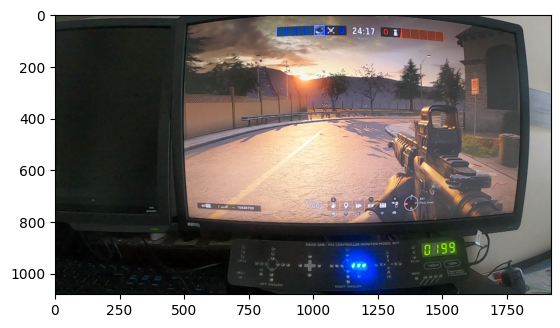

In [4]:
# Just to check the frames
temp_im = frames[5532]
plt.imshow(temp_im, cmap='gray')
plt.show()

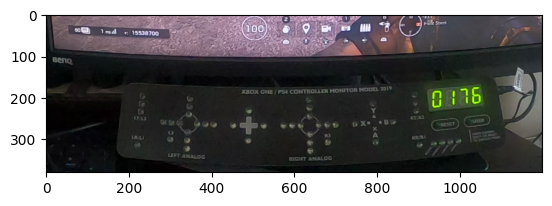

In [5]:
start_idx_x = 700
last_idx_x = 1080
start_idx_y = 500
last_idx_y = 1700

bottom_frame_set = []
for i in range(len(frames)):
    bottom_frame_set.append(frames[i][start_idx_x : last_idx_x, start_idx_y : last_idx_y])

temp_img = bottom_frame_set[0]
plt.imshow(temp_img, cmap='gray')
plt.show()

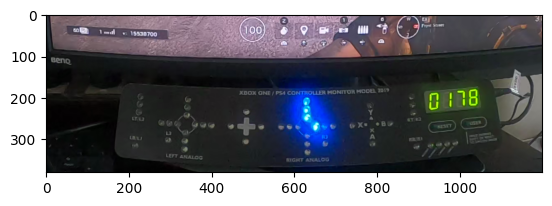

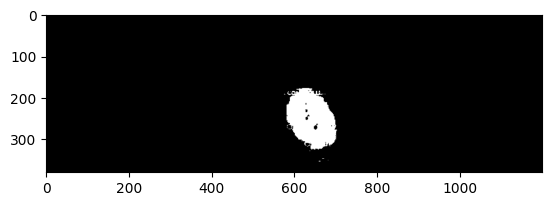

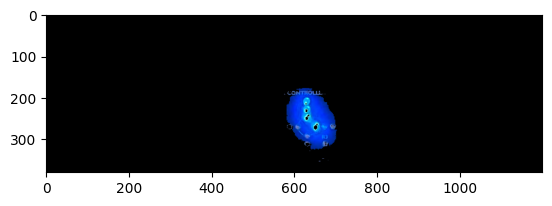

Total number of white pixels 12673


In [6]:
#450 Has 1 blip
# 422 to 423 has a blip in between

# Blue detection in the bottom images
temp_img = bottom_frame_set[423]

temp_img_hsv = cv2.cvtColor(temp_img, cv2.COLOR_RGB2HSV)

lower_blue = np.array([90, 100, 140])
upper_blue = np.array([150, 255, 255])

mask = cv2.inRange(temp_img_hsv, lower_blue, upper_blue)
result = cv2.bitwise_and(temp_img, temp_img, mask = mask)

plt.imshow(temp_img, cmap='gray')
plt.show()
plt.imshow(mask, cmap='gray')
plt.show()
plt.imshow(result, cmap='gray')
plt.show()

mask = np.array(mask)
print("Total number of white pixels " + str(int(np.sum(mask)/255)))

In [7]:
#450 Has 1 blip
# 422 to 423 has a blip in between

# Blue detection in the bottom images
trigger_points = np.zeros((len(frames)))
trigger_counted = False

for i in range(len(bottom_frame_set)):
    if i % 1000 == 0:
        print("Number of frames done "+ str(i))
    temp_img = bottom_frame_set[i]

    temp_img_hsv = cv2.cvtColor(temp_img, cv2.COLOR_RGB2HSV)

    lower_blue = np.array([90, 100, 140])
    upper_blue = np.array([150, 255, 255])

    mask = cv2.inRange(temp_img_hsv, lower_blue, upper_blue)
    result = cv2.bitwise_and(temp_img, temp_img, mask = mask)
    mask = np.array(mask)
    num_white_pix = int(np.sum(mask)/255)

    if num_white_pix > 300 and trigger_counted == False:
        trigger_points[i] = 1
        trigger_counted = True
    
    if num_white_pix <= 300:
        trigger_counted = False

print("All frames considered")

trigger_loc = []
for i in range(len(trigger_points)):
    if trigger_points[i] == 1:
        trigger_loc.append(i)

print("Number of trigger locations ", len(trigger_loc))
print("All the trigger locations ", trigger_loc)

Number of frames done 0
Number of frames done 1000
Number of frames done 2000
Number of frames done 3000
Number of frames done 4000
Number of frames done 5000
Number of frames done 6000
Number of frames done 7000
All frames considered
Number of trigger locations  25
All the trigger locations  [391, 758, 1014, 1248, 1515, 1747, 1996, 2307, 2590, 2880, 3173, 3448, 3708, 3999, 4240, 4480, 4765, 5020, 5265, 5512, 5751, 5962, 6205, 6410, 6625]


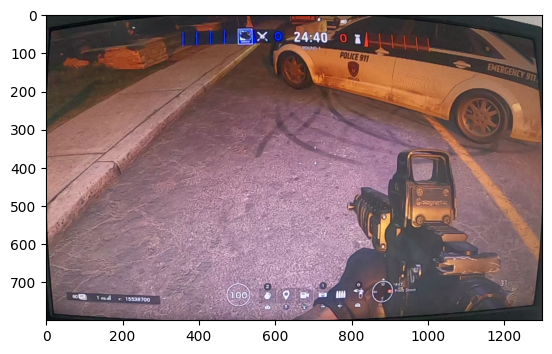

In [8]:
start_idx_x = 0
last_idx_x = 800
start_idx_y = 500
last_idx_y = 1800

top_frame_set = []
for i in range(len(frames)):
    top_frame_set.append(frames[i][start_idx_x : last_idx_x, start_idx_y : last_idx_y])

temp_img = top_frame_set[0]
plt.imshow(temp_img, cmap='gray')
plt.show()

In [9]:
# Taking boxes around these points
centre_idx_x = [200, 400, 600]
centre_idx_y = [200, 400, 600, 800, 1000, 1200]
size_xy = 20

old_frame = top_frame_set[0]
new_frame = top_frame_set[0]
min_ssim_values = []
for i in range(len(top_frame_set) - 10):
    old_frame = np.array(top_frame_set[i])
    new_frame = np.array(top_frame_set[i + 3])
    old_patches = []
    new_patches = []
    for j in range(len(centre_idx_x)):
        for k in range(len(centre_idx_y)):
            old_patches.append(old_frame[centre_idx_x[j] - size_xy : centre_idx_x[j] + size_xy,
                                        centre_idx_y[k] - size_xy : centre_idx_y[k] + size_xy, :])
            new_patches.append(new_frame[centre_idx_x[j] - size_xy : centre_idx_x[j] + size_xy,
                                        centre_idx_y[k] - size_xy : centre_idx_y[k] + size_xy, :])
    old_patches = np.array(old_patches)
    new_patches = np.array(new_patches)
    
    ssim_values = []
    for j in range(len(old_patches)):
        ssim_values.append(SSIM(old_patches[j], new_patches[j], channel_axis=2))
    ssim_values.sort()
    min_ssim_values.append(np.sum(ssim_values[:5]))

In [10]:
action_loc = []
ssim_threshold = 2.5
for val in trigger_loc:
    action_point_found = False
    for i in range(val, val + 50):
        if min_ssim_values[i] < ssim_threshold and action_point_found == False:
            action_loc.append(i)
            action_point_found = True
    if action_point_found == False:
        action_loc.append(-1)
print("All the action locations are " + str(action_loc))

All the action locations are [411, 780, 1031, 1267, 1539, 1770, 2019, 2329, 2614, 2898, 3193, 3469, 3732, 4017, 4260, 4499, 4783, 5043, 5286, 5534, 5774, 5983, 6230, 6430, 6645]


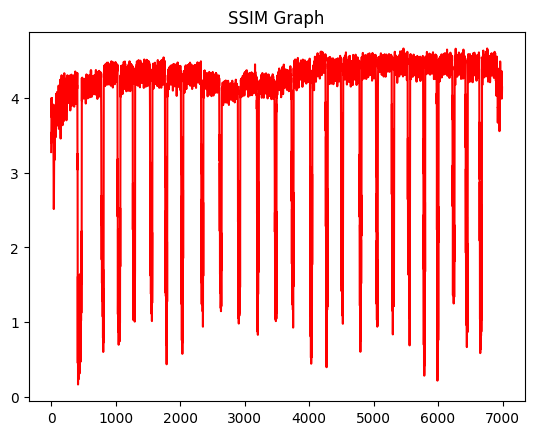

In [11]:
x = range(len(min_ssim_values))
y = min_ssim_values
plt.title("SSIM Graph")
plt.plot(y, color="red")

plt.show()

In [12]:
frame_diff = []
for i in range(len(action_loc)):
    frame_diff.append(action_loc[i] - trigger_loc[i])
print(frame_diff)

[20, 22, 17, 19, 24, 23, 23, 22, 24, 18, 20, 21, 24, 18, 20, 19, 18, 23, 21, 22, 23, 21, 25, 20, 20]


In [13]:
time_diff = []
for i in range(len(frame_diff)):
    time_diff.append(frame_diff[i] / frame_rate * 1000)
print(time_diff)

[83.41666666666667, 91.75833333333333, 70.90416666666667, 79.24583333333334, 100.10000000000001, 95.92916666666666, 95.92916666666666, 91.75833333333333, 100.10000000000001, 75.075, 83.41666666666667, 87.5875, 100.10000000000001, 75.075, 83.41666666666667, 79.24583333333334, 75.075, 95.92916666666666, 87.5875, 91.75833333333333, 95.92916666666666, 87.5875, 104.27083333333334, 83.41666666666667, 83.41666666666667]


In [14]:
average_time_difference = sum(time_diff) / len(time_diff)
print("The average time difference of the action is " + str(average_time_difference) + " milli-seconds")

The average time difference of the action is 87.92116666666666 milli-seconds


In [ ]:

# Camera Right.MP4 - Average Response time is 87.92 sec
